## Этот ноутбук содержит код подключения к Google Eartch Engine, конкретно, к созданному нами проекту `tsu-msccv-ecosystem-monitoring`. Также в этом ноутбуке исследуется возмодность применения SAM (Segment-Anything-Model) алгоритмов, к распознованию состояний леса по полученным спутниковым снимкам.

In [ ]:
import ee
import geemap
import leafmap
from samgeo import SamGeo
from samgeo.text_sam import LangSAM

In [ ]:
# auth.authenticate_user(project_id="tsu-msccv-ecosystem-monitoring")
ee.Authenticate()
ee.Initialize(project="tsu-msccv-ecosystem-monitoring")

In [ ]:
m = geemap.Map()

# Forest change data
img = ee.Image("UMD/hansen/global_forest_change_2023_v1_11")

# Eco regions map
east_siberian_taiga = ee.FeatureCollection('RESOLVE/ECOREGIONS/2017') \
  .filter("ECO_NAME == 'East Siberian taiga'")
  # .filter("ECO_NAME == 'Trans-Baikal Bald Mountain tundra'")

# Clip large image to east siberian taiga
img_clip = img.clip(east_siberian_taiga)
# Map position and zoom
m.set_center(112, 63, 4)

# Layers
tree_cover = {
    'bands': ['treecover2000'],
    "min": 0,
    "max" : 100,
    'palette': ['black', 'green']
}
m.add_layer(img_clip, tree_cover, 'tree_cover_2000')

tree_loss = {
    'bands': ['lossyear'],
    "min": 0,
    "max": 100,
    'palette': ['yellow', 'red']
}
m.addLayer(img_clip, tree_loss, 'loss_year')

tree_gain = {
  "bands": ['loss', 'treecover2000', 'gain'],
  "max": [1, 255, 1]
}
m.addLayer(img_clip, tree_gain, 'forest cover, loss, gain')

m

Map(center=[63, 112], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

In [ ]:
# Set cropping image size for testing
bbox = m.user_roi_coords()
if bbox is None:
    # bbox = [100, 53, 130.252, 73]
    bbox = [110, 58, 120, 63]

In [ ]:
# Saving image - different type

# geemap.ee_to_geotiff(
#     img_clip, "img_clip.tif", bbox, zoom=7, vis_params={"bands": ['lossyear', 'gain', 'last_b30']})
# geemap.show_image("img_clip.tif")


# m.layer_to_image("loss_year", output="loss_year.jpg", scale=1000)
# geemap.show_image("loss_year.jpg")

# m.layer_to_image("tree_gain", output="tree_gain.jpg", scale=1000)
# geemap.show_image("tree_gain.jpg")

m.layer_to_image("forest cover, loss, gain", output="flg.tif", region=bbox, scale=1000)
geemap.show_image("flg.tif")



flg.tif: |          | 0.00/3.79M (raw) [  0.0%] in 00:00 (eta:     ?)

Output()

In [ ]:
# Segment-geospatial class
sam = SamGeo(
    model_type="vit_h",
    device=None,
    sam_kwargs=None,
)

Model checkpoint for vit_h not found.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.56G/2.56G [00:18<00:00, 139MB/s]


In [ ]:
sam.generate("flg.tif", output="masks.tif", foreground=True, unique=True)

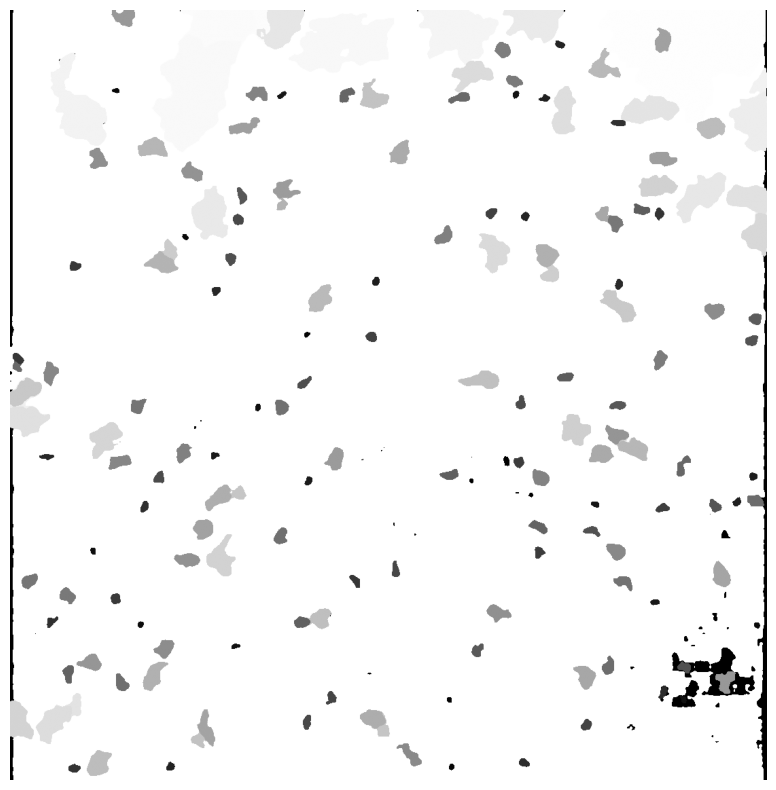

Map(bottom=37010.0, center=[61.80687922862542, 114.09301757812501], controls=(WidgetControl(options=['position…

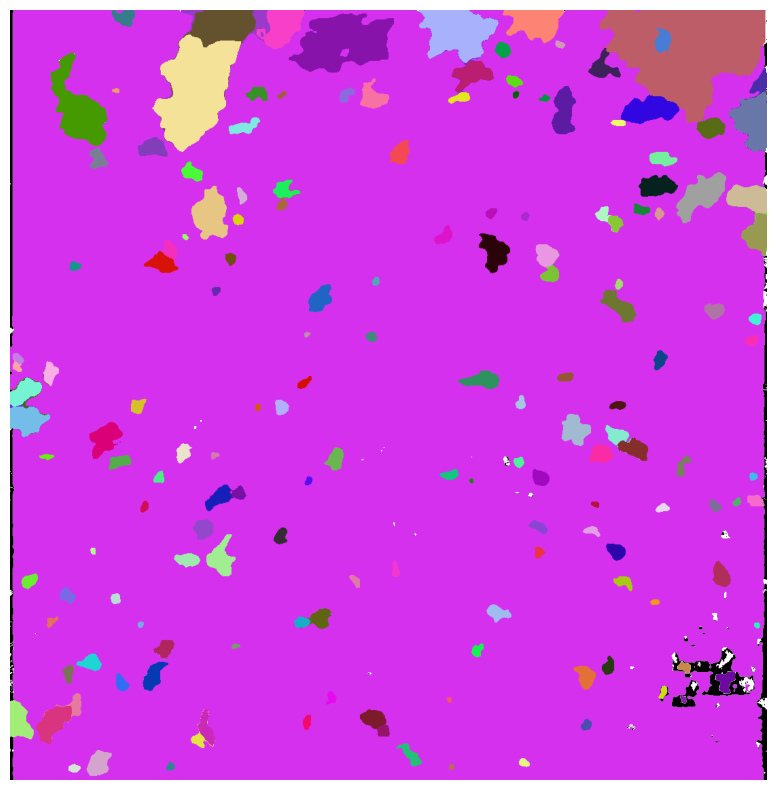

In [ ]:
sam.show_masks(cmap="binary_r")
sam.show_anns(axis="off", alpha=1, output="annotations.tif")
m.add_raster("annotations.tif", opacity=0.5, layer_name="Masks")
m

In [ ]:
sam.tiff_to_vector("masks.tif", "masks.shp")
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector("masks.shp", layer_name="Vector", style=style)
m

Map(bottom=5012.0, center=[60.50052541051131, 115.00076293945314], controls=(WidgetControl(options=['position'…